In [ ]:
# Step 0 : Data Preparation

# Import the necessary libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

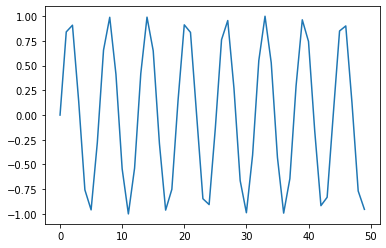

In [ ]:
# Creating & Visualizing the sine wave
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])

In [ ]:
# Create the data
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [ ]:
# Shape of the data
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [ ]:
# Create validation data
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [ ]:
# Step 1 : Create the Architecture for our RNN model

# Defining all the necessary variables and functions
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [ ]:
# Define the weights of the network

# Weights between input and hidden layers
U = np.random.uniform(0, 1, (hidden_dim, T))

# Weight matrix for shared weights in the RNN layer (hidden layer)
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))

# Weights between hidden and output layers
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [ ]:
 # Define the activation function
 def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# Step 2 : Train the Model

# Check the loss on training data
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        # get input, output values of each record
        x, y = X[i], Y[i]
        # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            # we then do a forward pass for every timestep in the sequence
            new_input = np.zeros(x.shape)
            # for this, we define a single input for that timestep
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])

    # Check the loss on validation data
    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

    # Start actual training & Forward Pass
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s

        # Backpropagate Error
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t

            # Update weights
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[116669.95324767]] , Val Loss:  [[58333.07377984]]
Epoch:  2 , Loss:  [[73369.84448977]] , Val Loss:  [[36683.40517495]]
Epoch:  3 , Loss:  [[40069.73573161]] , Val Loss:  [[20033.73656993]]
Epoch:  4 , Loss:  [[16769.62440169]] , Val Loss:  [[8384.06667809]]
Epoch:  5 , Loss:  [[3456.84646704]] , Val Loss:  [[1728.06012179]]
Epoch:  6 , Loss:  [[16.73189052]] , Val Loss:  [[8.33227536]]
Epoch:  7 , Loss:  [[27.44513034]] , Val Loss:  [[13.66214642]]
Epoch:  8 , Loss:  [[27.11797396]] , Val Loss:  [[13.50589063]]
Epoch:  9 , Loss:  [[27.27778692]] , Val Loss:  [[13.58972164]]
Epoch:  10 , Loss:  [[27.4617318]] , Val Loss:  [[13.67805568]]
Epoch:  11 , Loss:  [[27.42215575]] , Val Loss:  [[13.65729399]]
Epoch:  12 , Loss:  [[27.48036058]] , Val Loss:  [[13.69186267]]
Epoch:  13 , Loss:  [[27.63190872]] , Val Loss:  [[13.76241677]]
Epoch:  14 , Loss:  [[27.70220282]] , Val Loss:  [[13.7963596]]
Epoch:  15 , Loss:  [[27.6099718]] , Val Loss:  [[13.74983125]]
Epoch:  16

In [ ]:
# Step 3 : Get predictions

# Forward pass through the trained weights
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

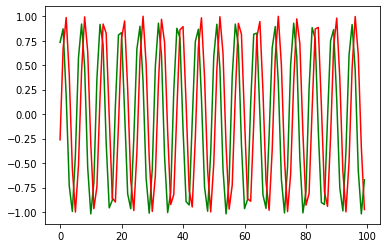

In [ ]:
# Plotting Predictions alongside the actual values
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

In [ ]:
# Using Validation Set

# Forward pass through the Valitdation Set
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

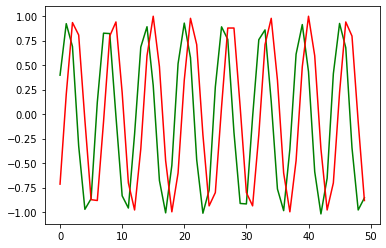

In [ ]:
# Plotting Predictions alongside the actual values
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [ ]:
# The RMSE score on the validation data 
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(Y_val[:, 0] * max_clip_value, preds[:, 0, 0] * max_clip_value))

7.944630522236879